In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans - serif"
rcParams["font.sans-serif"] = ["Verdana"]
rcParams["text.usetex"] = True


### TESS FLARES

In [3]:
#Importing in all of the TESS FLARES (classical/complex) 132
tess_flares= pd.read_csv('/Users/lupitatovar/TESS/all_tess_flares.txt',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]
tess_t_starts = tess_flares.loc[:,'t_start'].values
tess_t_stops = tess_flares.loc[:,'t_stop'].values
flux_peak = tess_flares.loc[:,'Flux_peak'].values
t_complex_flag = tess_flares.loc[:,'CPLX_flg'].values
tess_flares['Flare_Duration'] = 1440.*(tess_t_stops-tess_t_starts)

In [4]:
tess_flares41= pd.read_csv('/Users/lupitatovar/local_flares/final_flare_lists/TESS/tesss41.dat.fbeye',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]
tess_flares41['Flare_Duration'] = 1440.*(tess_flares41.loc[:,'t_stop'].values-tess_flares41.loc[:,'t_start'].values)

In [5]:
print(len(tess_flares41))
print(len(tess_flares))

51
132


In [6]:
#combining all the tess flares including s41
frames = [tess_flares,tess_flares41]
full_tess = pd.concat(frames)
#full_tess

In [7]:
# Separating the types of flares
tess_cplx1 = len([i for i in full_tess['CPLX_flg'].values if i < 2.0]) 
print ("The number of classical flares in TESS : " + str(tess_cplx1)) 

tess_cmplx2 = len([i for i in full_tess['CPLX_flg'].values if i > 1.0]) 
print ("The number of complex flares in TESS : " + str(tess_cmplx2)) 

t_complex_flares = full_tess[full_tess['CPLX_flg'] >= 2.0]
t_classical_flares = full_tess[full_tess['CPLX_flg'] == 1.0]

#-----------------------------------------------------------------------------------------
#min_dur = 20.0 #minutes
#max_dur = 75.0

#t_dur_limit = len([i for i in tess_flares['Flare_Duration'] if i >= min_dur and i<max_dur]) 
#print ("The number of total flares with a duration between 20-75min : " + str(t_dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
#t_classical_flares['Flare_Duration'] = 1440.*(t_classical_flares['t_stop'] - t_classical_flares['t_start'])
#classical_flares

#print (len([i for i in t_classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#tess_timed_classical = t_classical_flares[(t_classical_flares['Flare_Duration'] >= min_dur) & (t_classical_flares['Flare_Duration'] < max_dur)]
#print(len(t_complex_flares))

The number of classical flares in TESS : 58
The number of complex flares in TESS : 125


In [64]:
full_tess

,Event_ID,Start_INDX,Stop_INDX,t_peak,t_start,t_stop,t_rise,t_decay,Flux_peak,Equiv_Dur,S/N,CPLX_flg,MLTPK_flg,MLTPK_num,t_MLTPK,L_mltpk,MLTPK_INDX,quies,x,Flare_Duration
1,2,332.0,336.0,1683.831182,1683.828405,1683.833960,0.002778,0.002778,0.004359,1.039416,0.856315,4.0,0.0,0.0,0.0,0.0,0.0,11337.21094,;,8.000106
2,3,618.0,622.0,1684.233965,1684.232576,1684.238132,0.001389,0.004167,0.004396,1.021397,0.698504,4.0,0.0,0.0,0.0,0.0,0.0,11377.51562,;,8.000103
3,4,676.0,685.0,1684.315911,1684.313133,1684.325633,0.002778,0.009722,0.011388,4.056827,1.721060,4.0,0.0,0.0,0.0,0.0,0.0,11337.41602,;,18.000231
4,5,1619.0,1628.0,1685.624261,1685.622872,1685.635372,0.001389,0.011111,0.007767,2.732755,1.365432,4.0,0.0,0.0,0.0,0.0,0.0,11342.76758,;,18.000222
5,6,1655.0,1661.0,1685.674261,1685.672872,1685.681206,0.001389,0.006945,0.006291,1.887355,1.065632,4.0,0.0,0.0,0.0,0.0,0.0,11338.58984,;,12.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,57,10134.0,10142.0,2435.203239,2435.197683,2435.208794,0.005556,0.005556,0.004420,1.816458,1.095057,4.0,0.0,0.0,0.0,0.0,0.0,11302.00879,;,15.999987
48,58,10750.0,10849.0,2436.058794,2436.054627,2436.192127,0.004167,0.133333,0.039386,127.881465,10.561373,1.0,0.0,0.0,0.0,0.0,0.0,11299.08105,;,197.999829
49,59,11061.0,11084.0,2436.492127,2436.486571,2436.518515,0.005556,0.026389,0.011841,8.704707,2.393503,2.0,0.0,0.0,0.0,0.0,0.0,11317.58105,;,45.999958
50,60,13780.0,13797.0,2440.281011,2440.272677,2440.296288,0.008333,0.015278,0.006244,3.916223,1.463201,1.0,0.0,0.0,0.0,0.0,0.0,11324.44336,;,33.999943


In [8]:
len(t_complex_flares)

125

In [9]:
#t_complex_flares.to_csv('TESS_cmplx_flares_no_dur_lim.csv')

In [10]:
#t_classical_flares.to_csv('TESS_classical_flares_no_dur_lim.csv')

In [11]:
#tess stacked flares
fit_flare_vals=pd.read_csv('/Users/lupitatovar/local_flares/notebooks/s41_tess_stacked_fit_flare_vals.csv') #this one includes s41

In [291]:
fit_flare_vals

,Unnamed: 0,time,flux,flux_err,gp_st_dev
0,0,-0.596617,-0.065043,0.122842,0.039365
1,1,-0.335374,0.381376,0.123003,0.039371
2,2,-0.074130,0.907677,0.123513,0.039337
3,3,0.187113,0.887617,0.123323,0.039263
4,4,0.448356,0.597370,0.123316,0.039148
...,...,...,...,...,...
691,691,1.070707,0.452503,0.389444,0.117222
692,692,1.243141,0.644063,0.389200,0.116948
693,693,1.415576,0.635684,0.389422,0.116540
694,694,1.588010,0.143802,0.389133,0.116003


In [12]:
#this list includes s41 but they are all w/in a time limit of 20-75min
tess_classics_dur = pd.read_csv('/Users/lupitatovar/local_flares/notebooks/tess_classical_flare_table.csv')
print(len(tess_classics_dur))

36


In [13]:
#all tess classical flares (including s41) s/o time limits
tess_classics = pd.read_csv('TESS_classical_flares_no_dur_lim.csv')
print(len(tess_classics))

58


In [14]:
#all tess complex flares (including s41) s/o time limits
tess_complex = pd.read_csv('TESS_cmplx_flares_no_dur_lim.csv')
print(len(tess_complex))

125


### Kepler Flares

In [15]:
#2014 Flares List

flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak'].values
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [16]:
# Separating the types of flares
k_classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(k_classical)) 

k_cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(k_cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

The number of classical flares : 5162
The number of complex flares : 945


In [17]:
#classical_flares.to_csv('Kepler_classical_flares_no_dur_lim.csv')

In [18]:
kepler_classics=pd.read_csv('Kepler_classical_flares_no_dur_lim.csv')
print(len(kepler_classics))

5162


In [19]:
#these have a time duration limit 
kepler_classics_dur = pd.read_csv('/Users/lupitatovar/local_flares/final_flare_lists/Kepler/gj1243_kepler_classical_flares_list.csv')
print(len(kepler_classics_dur))

414


In [20]:
kepler_complex_flares = pd.read_csv('/Users/lupitatovar/local_flares/notebooks/kepler_complex_flares.csv')
print(len(kepler_complex_flares))

945


Importing in GP

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


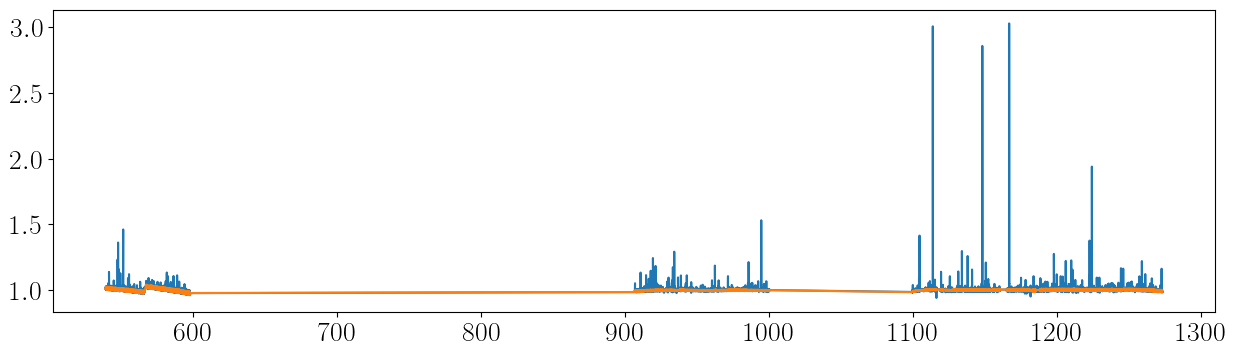

In [338]:
from glob import glob

gp_files = glob('/Users/lupitatovar/local_flares/notebooks/*11mo*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()

0 (18522, 7)
1 (17848, 7)
2 (18322, 7)


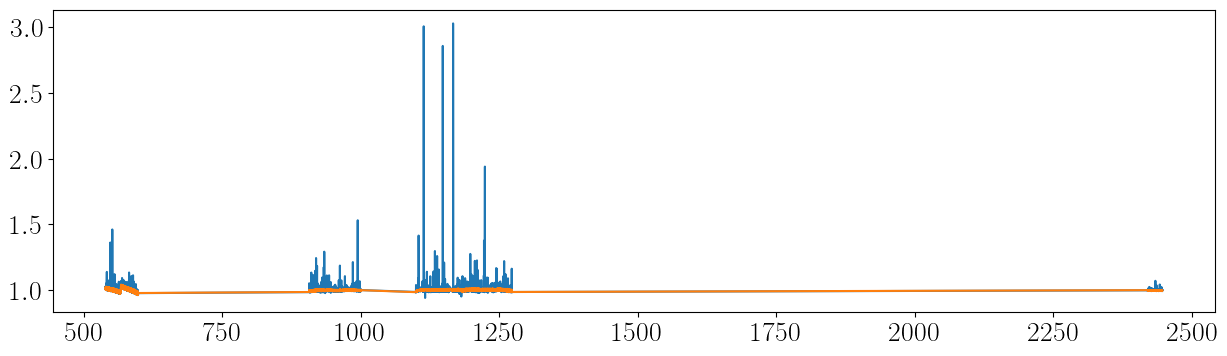

In [339]:
tess_gp_files = glob('/Users/lupitatovar/local_flares/notebooks/*tess_gp*.csv')

for k in range(len(tess_gp_files)): 
    df_tmp_t = pd.read_csv(tess_gp_files[k]) 
    print(k, df_tmp_t.shape) 
    if k==0: 
        df_t = df_tmp_t 
    else: 
         df_t = df.append(df_tmp_t) 

df_t = df_t.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df_t['time'], df_t['detrended_flux'])
plt.plot(df_t['time'], df_t['mean'])
plt.show()

In [340]:
detrended_kepler = df['detrended_flux'].values - df['mean'].values
kepler_errors = np.sqrt((df['df_flux_err'].values)**2 + (df['std'].values) )

Importing in the Kepler flares that were fit using my new model

In [ ]:
kfits = pd.read_csv('')

In [21]:
import sys  
sys.path.append('/Users/lupitatovar/Llamaradas-Estelares/') #Edit this to your own file path
from Flare_model import flare_model

In [22]:
#flare equivalent durations + luminosity
tess_Lo= 30.352907 #tess val
tess_energy_full = np.log10(full_tess['Equiv_Dur'].values) + tess_Lo
t_durations = full_tess['t_stop'].values-full_tess['t_start'].values
t_durations_min = t_durations*1440

k_durations = flare_table['t_stop'].values-flare_table['t_start'].values
k_durations_classics = kepler_classics['t_stop'].values-kepler_classics['t_start'].values
k_durations_cmplx = kepler_complex_flares['t_stop'].values-kepler_complex_flares['t_start'].values
k_durations_min = k_durations*1440
k_Lo= 30.037849 
k_energy_full = np.log10(flare_table['ED'].values) + k_Lo

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


Loading in new kepler amps that I measured independently of FBEYE and the flare model

In [358]:
kep_new_amps = pd.read_csv('kepler_new_amps.csv')
kep_new_amps['Amps'].values

array([0.0018405 , 0.00793085, 0.00239538, ..., 0.00841962, 0.00249974,
       0.00233734])

In [23]:
print(len(full_tess))
print(len(flare_table))
print(len(k_energy_full))

183
6107
6107


In [361]:
print(len(kep_new_amps['Amps'].values))
print(len(flare_table['flux peak'].values))

6107
6107


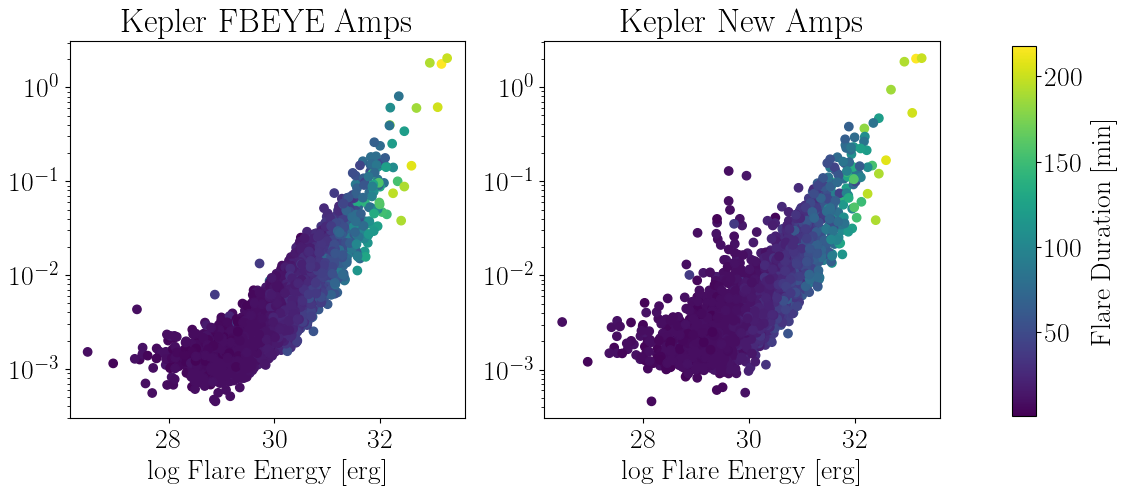

In [360]:


fig, axs = plt.subplots(1,2, figsize=(12,5), facecolor='w', edgecolor='k')


axs[0].scatter(k_energy_full,flare_table['flux peak'].values,c=k_durations_min)

axs[0].set_yscale('log')
axs[0].set_xlabel('log Flare Energy [erg]')
axs[0].set_title("Kepler FBEYE Amps")

axs[1].scatter(k_energy_full,kep_new_amps['Amps'].values,c=k_durations_min)

axs[1].set_yscale('log')
axs[1].set_xlabel('log Flare Energy [erg]')
axs[1].set_title("Kepler New Amps")


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.91, 0.13, 0.02, 0.74])
s = plt.scatter(k_energy_full,kep_new_amps['Amps'].values,marker='o',c=k_durations_min)
fig.colorbar(s, cax=cbar_ax,label='Flare Duration [min]')

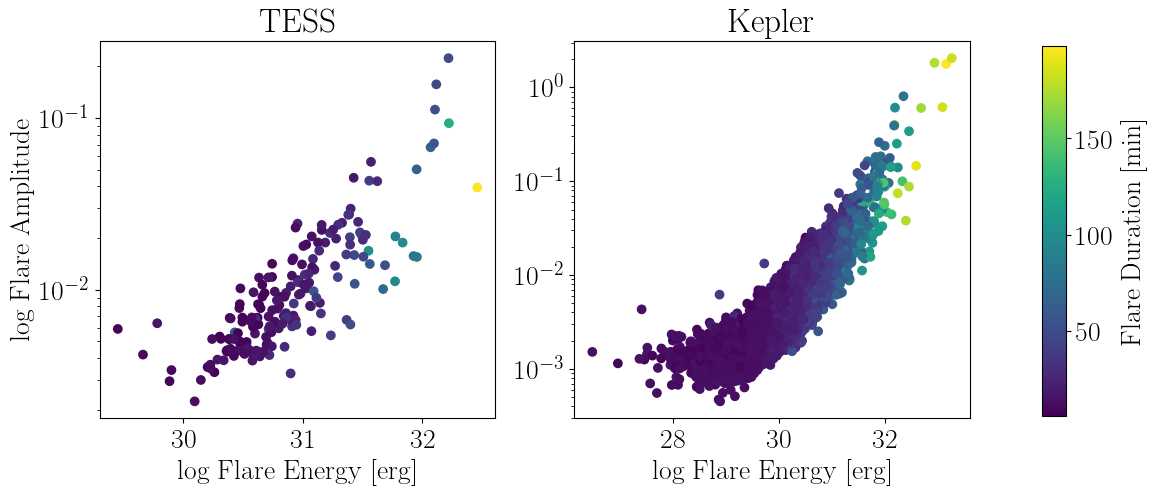

In [24]:

fig, axs = plt.subplots(1,2, figsize=(12,5), facecolor='w', edgecolor='k')


axs[0].scatter(tess_energy_full,full_tess['Flux_peak'].values,marker='o',c=t_durations_min)

axs[0].set_ylabel('log Flare Amplitude')
axs[0].set_xlabel('log Flare Energy [erg]')
axs[0].set_yscale('log')
axs[0].set_title("TESS")

axs[1].scatter(k_energy_full,flare_table['flux peak'].values,c=k_durations_min)

axs[1].set_yscale('log')
axs[1].set_xlabel('log Flare Energy [erg]')
axs[1].set_title("Kepler")


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.91, 0.13, 0.02, 0.74])
s = plt.scatter(tess_energy_full,full_tess['Flux_peak'].values,marker='o',c=t_durations_min)
fig.colorbar(s, cax=cbar_ax,label='Flare Duration [min]')

Now only the classical flares from each data set

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


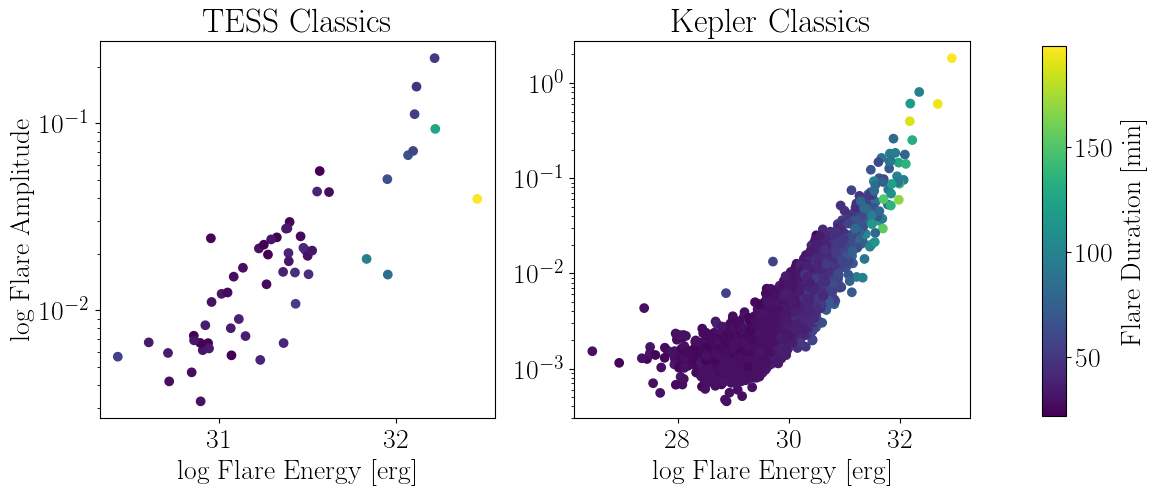

In [25]:
tess_energy_classic = np.log10(tess_classics['Equiv_Dur'].values) + tess_Lo
t_durations_classic = tess_classics['t_stop'].values-tess_classics['t_start'].values
t_durations_min_cl = t_durations_classic*1440

k_energy_classic = np.log10(kepler_classics['ED'].values) + k_Lo

fig, axs = plt.subplots(1,2, figsize=(12,5), facecolor='w', edgecolor='k')


axs[0].scatter(tess_energy_classic,tess_classics['Flux_peak'].values,marker='o',c=t_durations_min_cl)

axs[0].set_ylabel('log Flare Amplitude')
axs[0].set_xlabel('log Flare Energy [erg]')
axs[0].set_yscale('log')
axs[0].set_title("TESS Classics")

axs[1].scatter(k_energy_classic,kepler_classics['flux peak'].values,c=k_durations_classics*1440)

axs[1].set_yscale('log')
axs[1].set_xlabel('log Flare Energy [erg]')
axs[1].set_title("Kepler Classics")


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.91, 0.13, 0.02, 0.74])
s1 = plt.scatter(tess_energy_classic,tess_classics['Flux_peak'].values,marker='o',c=t_durations_min_cl)
fig.colorbar(s1, cax=cbar_ax,label='Flare Duration [min]')

In [26]:
print(len(tess_classics))
print(len(kepler_classics))
print(len(k_energy_classic))

58
5162
5162


Now only the complex flares from each data set

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


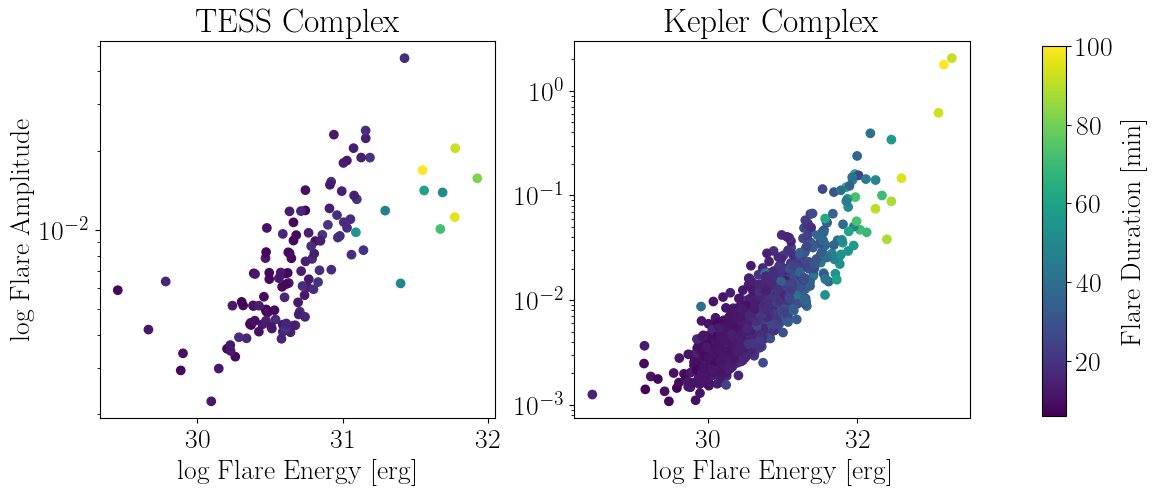

In [27]:
tess_energy_complex = np.log10(tess_complex['Equiv_Dur'].values) + tess_Lo
t_durations_complex = tess_complex['t_stop'].values-tess_complex['t_start'].values
t_durations_min_cx = t_durations_complex*1440

k_energy_complex = np.log10(kepler_complex_flares['ED'].values) + k_Lo

fig, axs = plt.subplots(1,2, figsize=(12,5), facecolor='w', edgecolor='k')


axs[0].scatter(tess_energy_complex,tess_complex['Flux_peak'].values,marker='o',c=t_durations_min_cx)

axs[0].set_ylabel('log Flare Amplitude')
axs[0].set_xlabel('log Flare Energy [erg]')
axs[0].set_yscale('log')
axs[0].set_title("TESS Complex")

axs[1].scatter(k_energy_complex,kepler_complex_flares['flux peak'].values,c=k_durations_cmplx*1440)

axs[1].set_yscale('log')
axs[1].set_xlabel('log Flare Energy [erg]')
axs[1].set_title("Kepler Complex")


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.91, 0.13, 0.02, 0.74])
s2 = plt.scatter(tess_energy_complex,tess_complex['Flux_peak'].values,marker='o',c=t_durations_min_cx)
fig.colorbar(s2, cax=cbar_ax,label='Flare Duration [min]')

In [28]:
print(len(tess_complex))
print(len(kepler_complex_flares))
print(len(k_energy_complex))

125
945
945


Overlaying

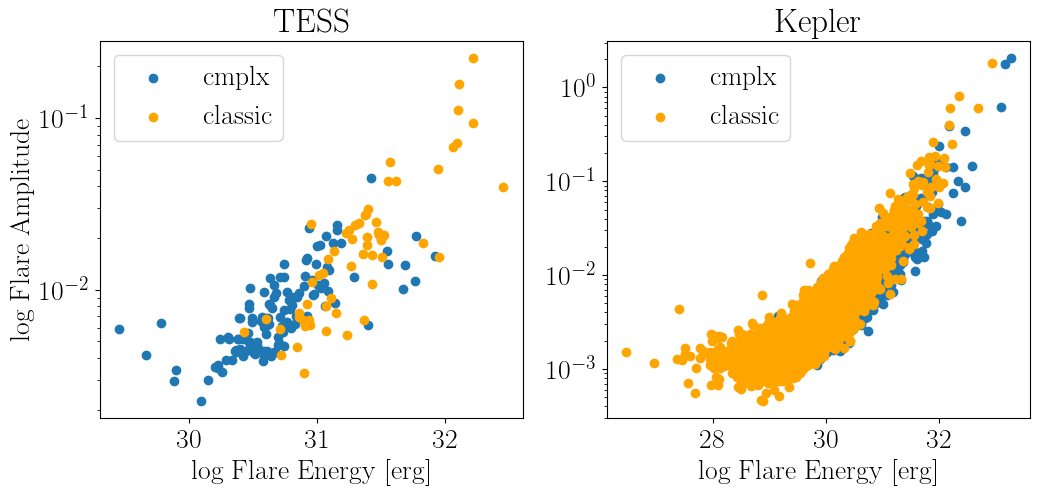

In [29]:


fig, axs = plt.subplots(1,2, figsize=(12,5), facecolor='w', edgecolor='k')


axs[0].scatter(tess_energy_complex,tess_complex['Flux_peak'].values,marker='o',label='cmplx',color='C0')
axs[0].scatter(tess_energy_classic,tess_classics['Flux_peak'].values,marker='o',label='classic',color='orange')

axs[0].set_ylabel('log Flare Amplitude')
axs[0].set_xlabel('log Flare Energy [erg]')
axs[0].set_yscale('log')
axs[0].set_title("TESS")
axs[0].legend()

axs[1].scatter(k_energy_complex,kepler_complex_flares['flux peak'].values,label='cmplx',color='C0')
axs[1].scatter(k_energy_classic,kepler_classics['flux peak'].values,label='classic',color='orange')

axs[1].set_yscale('log')
axs[1].set_xlabel('log Flare Energy [erg]')
axs[1].set_title("Kepler")
axs[1].legend()

#fig.subplots_adjust(right=0.85)
#cbar_ax = fig.add_axes([0.91, 0.13, 0.02, 0.74])
#s2 = plt.scatter(tess_energy_complex,tess_complex['Flux_peak'].values,marker='o',c=t_durations_min_cx)
#fig.colorbar(s2, cax=cbar_ax,label='Flare Duration [min]')

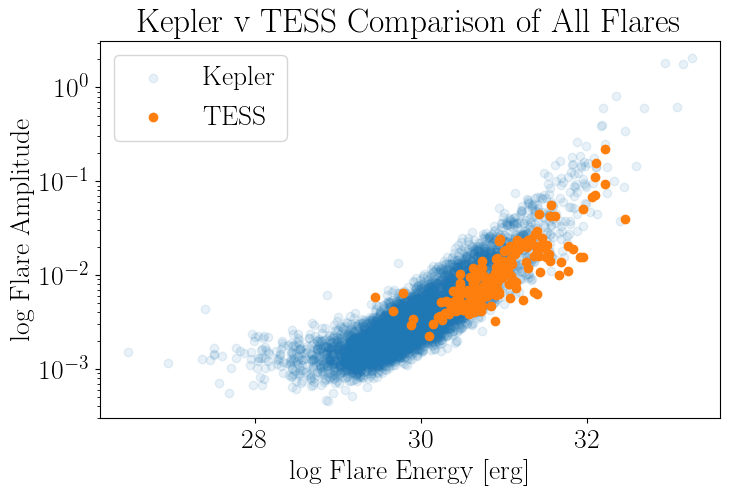

In [30]:

plt.scatter(k_energy_complex,kepler_complex_flares['flux peak'].values,label='Kepler',color='C0',alpha=.1)
plt.scatter(k_energy_classic,kepler_classics['flux peak'].values,color='C0',alpha=.1)

plt.scatter(tess_energy_complex,tess_complex['Flux_peak'].values,marker='o',label='TESS',color='C1')
plt.scatter(tess_energy_classic,tess_classics['Flux_peak'].values,marker='o',color='C1')


plt.yscale('log')
plt.xlabel('log Flare Energy [erg]')
plt.ylabel('log Flare Amplitude')
plt.title("Kepler v TESS Comparison of All Flares")
plt.legend()
plt.yscale('log')

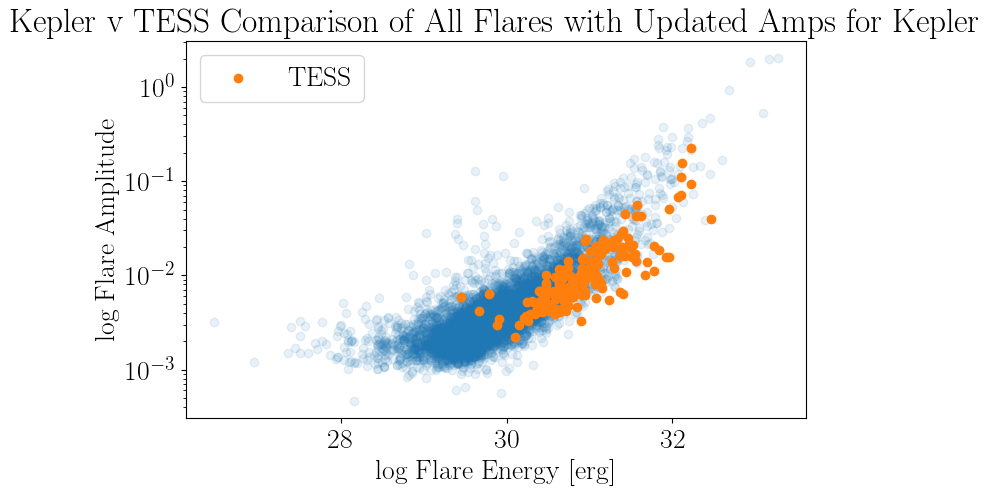

In [363]:


plt.scatter(k_energy_full,kep_new_amps['Amps'].values,color='C0',alpha=.1)

plt.scatter(tess_energy_complex,tess_complex['Flux_peak'].values,marker='o',label='TESS',color='C1')
plt.scatter(tess_energy_classic,tess_classics['Flux_peak'].values,marker='o',color='C1')


plt.yscale('log')
plt.xlabel('log Flare Energy [erg]')
plt.ylabel('log Flare Amplitude')
plt.title("Kepler v TESS Comparison of All Flares with Updated Amps for Kepler")
plt.legend()
plt.yscale('log')

### import in Max's flare stars from 2020 paper (TESS sectors 1-2) 
https://ui.adsabs.harvard.edu/abs/2020AJ....159...60G/abstract

In [33]:
max2020 = pd.read_csv('max2020.tsv', sep='\t', skiprows=83)
max2020

,TIC,Outbst,Flare,tpeak,e_tpeak,E_tpeak,Amp,e_Amp,E_Amp,FWHMdt,...,Teff,Rad,logg,SpT,Prot-t,Prot-k,Prot,Chem,O3cons,O3perm
0,2760232,1,1,2.458357e+06,0.000863,0.000854,0.01475,0.00168,0.00170,0.01958,...,,0.225556,5.02139,,0.399300,,0.399300,0,0,0
1,2760232,2,1,2.458358e+06,0.001059,0.001026,0.01389,0.00162,0.00175,0.01612,...,,0.225556,5.02139,,0.399300,,0.399300,0,0,0
2,2760232,3,1,2.458360e+06,0.000026,0.000026,0.28258,0.00817,0.00949,0.00196,...,,0.225556,5.02139,,0.399300,,0.399300,0,0,0
3,2760232,3,2,2.458360e+06,0.000195,0.000195,0.04634,0.00589,0.00598,0.00610,...,,0.225556,5.02139,,0.399300,,0.399300,0,0,0
4,2760232,3,3,2.458360e+06,0.001735,0.001565,0.01665,0.00185,0.00155,0.05816,...,,0.225556,5.02139,,0.399300,,0.399300,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8690,471015484,9,1,2.458371e+06,0.000070,0.000073,0.13585,0.00572,0.00568,0.00254,...,,0.417000,4.83963,,,,,0,0,0
8691,471015484,10,1,2.458373e+06,0.000201,0.000249,0.04478,0.00437,0.00442,0.00410,...,,0.417000,4.83963,,,,,0,0,0
8692,471015484,10,2,2.458373e+06,0.000323,0.000329,0.02797,0.00334,0.00339,0.00744,...,,0.417000,4.83963,,,,,0,0,0
8693,471015484,11,1,2.458379e+06,0.000151,0.000161,0.03871,0.00519,0.00646,0.00266,...,,0.417000,4.83963,,,,,0,0,0


In [53]:
max2 = pd.read_csv('max2.tsv', sep='|', skiprows=8)#,delim_whitespace=True)
max2

,,.1,.2,d,d.1,d.2,.3,.4,.5,d.3,...,K,Rsun,[cm/s2],.6,d.6,d.7,d.8,.7,.8,Unnamed: 28
0,---------,--,-,--------------,---------,---------,--------,--------,--------,--------,...,-----,---------,--------,------,---------,---------,---------,-,-,-
1,2760232,1,1,2458357.381046,0.000863,0.000854,0.01475,0.00168,0.00170,0.01958,...,,0.225556,5.02139,,0.399300,,0.399300,0,0,0
2,2760232,2,1,2458357.843604,0.001059,0.001026,0.01389,0.00162,0.00175,0.01612,...,,0.225556,5.02139,,0.399300,,0.399300,0,0,0
3,2760232,3,1,2458359.790770,0.000026,0.000026,0.28258,0.00817,0.00949,0.00196,...,,0.225556,5.02139,,0.399300,,0.399300,0,0,0
4,2760232,3,2,2458359.793415,0.000195,0.000195,0.04634,0.00589,0.00598,0.00610,...,,0.225556,5.02139,,0.399300,,0.399300,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8691,471015484,9,1,2458370.922249,0.000070,0.000073,0.13585,0.00572,0.00568,0.00254,...,,0.417000,4.83963,,,,,0,0,0
8692,471015484,10,1,2458373.463365,0.000201,0.000249,0.04478,0.00437,0.00442,0.00410,...,,0.417000,4.83963,,,,,0,0,0
8693,471015484,10,2,2458373.469111,0.000323,0.000329,0.02797,0.00334,0.00339,0.00744,...,,0.417000,4.83963,,,,,0,0,0
8694,471015484,11,1,2458378.504693,0.000151,0.000161,0.03871,0.00519,0.00646,0.00266,...,,0.417000,4.83963,,,,,0,0,0


In [37]:
max2020['Amp'].values

array([0.01475, 0.01389, 0.28258, ..., 0.02797, 0.03871, 0.10938])

In [49]:
(max2020['Ebol'].values)

array(['         ', '         ', '         ', ..., '         ',
       '         ', '         '], dtype=object)

In [48]:
np.array(max2020['Ebol'].values)

ValueError: could not convert string to float: 

In [56]:
ebol_mask = max2020['Ebol']!=max2020['Ebol'][0]
ebol_array = np.array(max2020['Ebol'].values[ebol_mask],dtype = float)

In [57]:
ebol_array

array([2.07e+32, 1.41e+32, 3.36e+31, ..., 1.04e+33, 6.24e+32, 4.85e+33])

In [60]:
np.log10(ebol_array)

array([32.31597035, 32.14921911, 31.52633928, ..., 33.01703334,
       32.79518459, 33.68574174])

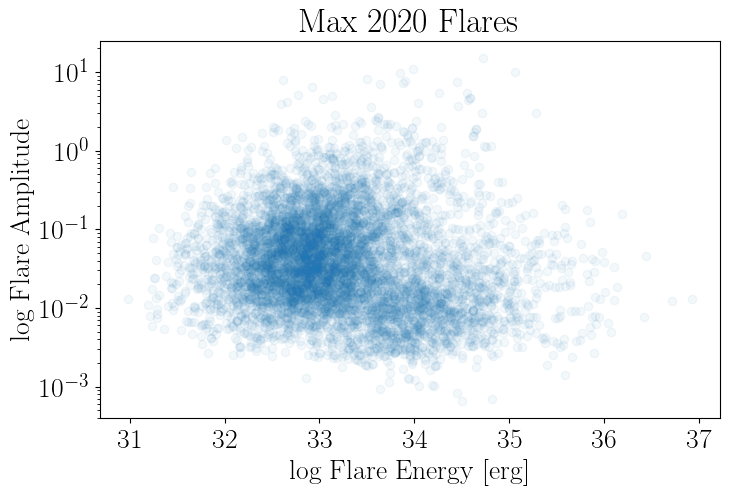

In [61]:
plt.scatter(np.log10(ebol_array),max2020['Amp'].values[ebol_mask],alpha=0.05)

plt.xlabel('log Flare Energy [erg]')
plt.ylabel('log Flare Amplitude')
plt.title("Max 2020 Flares")
#plt.xscale('log')
plt.yscale('log')

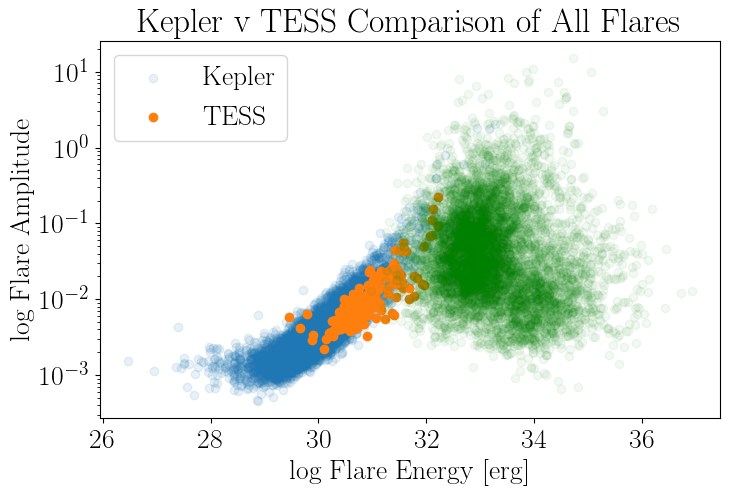

In [63]:

plt.scatter(k_energy_complex,kepler_complex_flares['flux peak'].values,label='Kepler',color='C0',alpha=.1)
plt.scatter(k_energy_classic,kepler_classics['flux peak'].values,color='C0',alpha=.1)

plt.scatter(tess_energy_complex,tess_complex['Flux_peak'].values,marker='o',label='TESS',color='C1')
plt.scatter(tess_energy_classic,tess_classics['Flux_peak'].values,marker='o',color='C1')

plt.scatter(np.log10(ebol_array),max2020['Amp'].values[ebol_mask],alpha=0.05,color='green')


plt.yscale('log')
plt.xlabel('log Flare Energy [erg]')
plt.ylabel('log Flare Amplitude')
plt.title("Kepler v TESS Comparison of All Flares")
plt.legend()
plt.yscale('log')

### Fitting the various flare data

In [74]:
#mask for fitting data greater than log E 30
gt30 = np.where(k_energy_full >= 30)

In [73]:
k_energy_full

array([29.76568985, 30.45304278, 29.57418393, ..., 30.05154073,
       29.30846496, 28.94253534])

In [66]:
print(len(k_energy_full))
print(len(flare_table['flux peak'].values))

6107
6107


In [364]:
### Kepler ####
kep_xfit = k_energy_full[gt30]
kep_yfit = kep_new_amps['Amps'].values[gt30]
kep_z = np.polyfit(kep_xfit,kep_yfit,5)
kep_p = np.poly1d(kep_z)
print(kep_xfit)
print(kep_yfit)
print(kep_p)

[30.45304278 30.0284085  30.01627167 ... 30.01097501 30.44961427
 30.05154073]
[0.00793085 0.00952001 0.00719707 ... 0.01158405 0.01158405 0.00841962]
         5         4         3        2
0.02036 x - 3.136 x + 193.3 x - 5954 x + 9.173e+04 x - 5.652e+05


Text(0, 0.5, 'log Flare Amplitude')

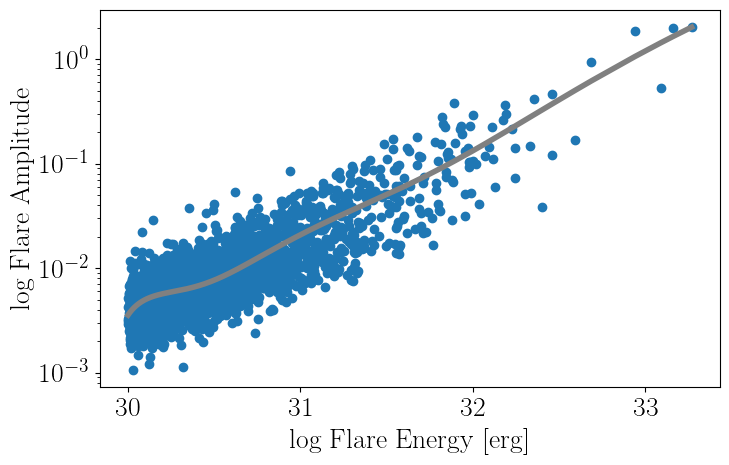

In [365]:
kep_sorted = np.sort(kep_xfit)
plt.scatter(kep_xfit,kep_yfit)
plt.plot(kep_sorted, kep_p(kep_sorted), '-',color='grey',lw=4,label='3rd order polynomial')
plt.yscale('log')
plt.xlabel('log Flare Energy [erg]')
plt.ylabel('log Flare Amplitude')

In [370]:
### TESS ####
tess_maskgt30 = np.where(tess_energy_full >=30)
tess_xfit =tess_energy_full[tess_maskgt30]
tess_yfit = full_tess['Flux_peak'].values[tess_maskgt30]
tess_z = np.polyfit(tess_xfit,tess_yfit,3)
tess_p = np.poly1d(tess_z)
#print(tess_xfit)
#print(tess_yfit)
print(tess_p)

         3         2
0.01641 x - 1.505 x + 46.01 x - 468.9


Text(0, 0.5, 'log Flare Amplitude')

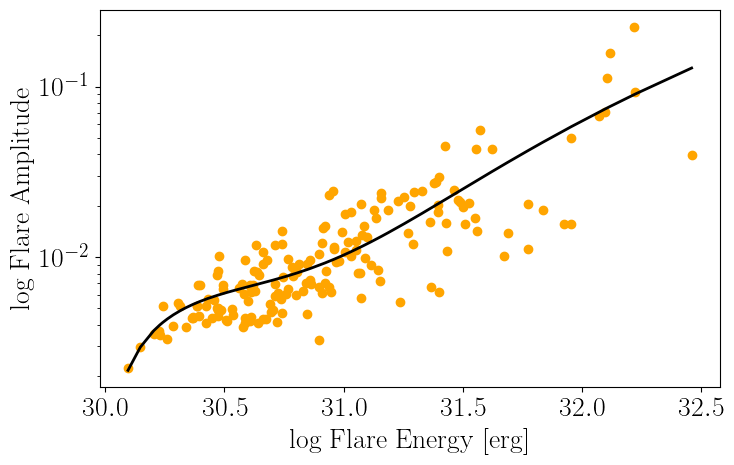

In [371]:
tess_sorted = np.sort(tess_xfit)
plt.scatter(tess_xfit,tess_yfit,color='orange')
plt.plot(tess_sorted, tess_p(tess_sorted), '-',color='k',lw=2,label='3rd order polynomial')
plt.yscale('log')
plt.xlabel('log Flare Energy [erg]')
plt.ylabel('log Flare Amplitude')

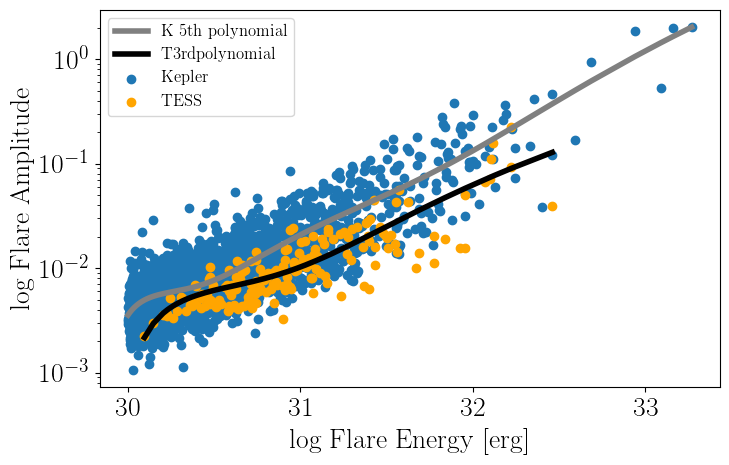

In [372]:
plt.scatter(kep_xfit,kep_yfit,label='Kepler')
plt.plot(kep_sorted, kep_p(kep_sorted), '-',color='grey',lw=4,label='K 5th polynomial')


plt.scatter(tess_xfit,tess_yfit,color='orange',label='TESS')
plt.plot(tess_sorted, tess_p(tess_sorted), '-',color='k',lw=4,label='T3rdpolynomial')
plt.yscale('log')
plt.xlabel('log Flare Energy [erg]')
plt.ylabel('log Flare Amplitude')
plt.legend(fontsize=12)

### Fitting in log space

In [355]:
len(kep_yfit)

2373

In [147]:
min(np.log10(kep_yfit))

-2.8182421365313233

In [373]:
### Kepler ####
kep_xfit = k_energy_full[gt30]
kep_yfit_log = np.log10(kep_yfit)
kep_z_log,cov = np.polyfit(kep_xfit,kep_yfit_log,3,cov=True)
kep_p_log = np.poly1d(kep_z_log)
#print(kep_xfit)
#print(kep_yfit)
#print(kep_p)
print(cov)

[[ 1.87004325e-04 -1.74843618e-02  5.44697311e-01 -5.65419703e+00]
 [-1.74843618e-02  1.63490005e+00 -5.09376826e+01  5.28806368e+02]
 [ 5.44697310e-01 -5.09376825e+01  1.58719015e+03 -1.64788744e+04]
 [-5.65419702e+00  5.28806368e+02 -1.64788744e+04  1.71106508e+05]]


In [401]:
print(kep_p_log)

          3         2
-0.01786 x + 1.758 x - 56.77 x + 600.5


In [374]:
### TESS ####
tess_maskgt30 = np.where(tess_energy_full >=30)
tess_xfit =tess_energy_full[tess_maskgt30]
tess_yfit_log = np.log10(tess_yfit)
tess_z_log,tcov = np.polyfit(tess_xfit,tess_yfit_log,3,cov=True)
tess_p_log = np.poly1d(tess_z_log)
#print(tess_xfit)
#print(tess_yfit)
print(tess_p)
print(tess_p_log)

         3         2
0.01641 x - 1.505 x + 46.01 x - 468.9
         3         2
0.05967 x - 5.531 x + 171.4 x - 1779


In [375]:
print(kep_p_log(1000))
print(tess_p_log(1000))

-16154274.00245824
54306774.69860807


In [376]:
tess_z_log

array([ 5.96679787e-02, -5.53087150e+00,  1.71446713e+02, -1.77923136e+03])

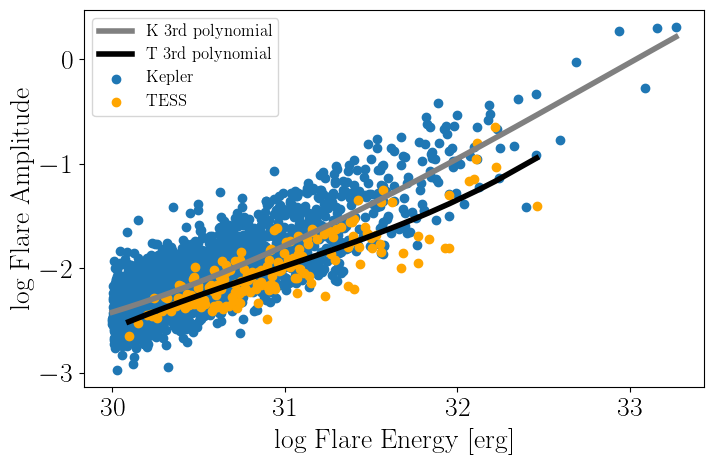

In [377]:
plt.scatter(kep_xfit,kep_yfit_log,label='Kepler')
plt.plot(kep_sorted, kep_p_log(kep_sorted), '-',color='grey',lw=4,label='K 3rd polynomial')


plt.scatter(tess_xfit,tess_yfit_log,color='orange',label='TESS')
plt.plot(tess_sorted, tess_p_log(tess_sorted), '-',color='k',lw=4,label='T 3rd polynomial')


#plt.yscale('log')
plt.xlabel('log Flare Energy [erg]')
plt.ylabel('log Flare Amplitude')
plt.legend(fontsize=12)

Side by side comparisons

Text(0.5, 1.0, 'log space')

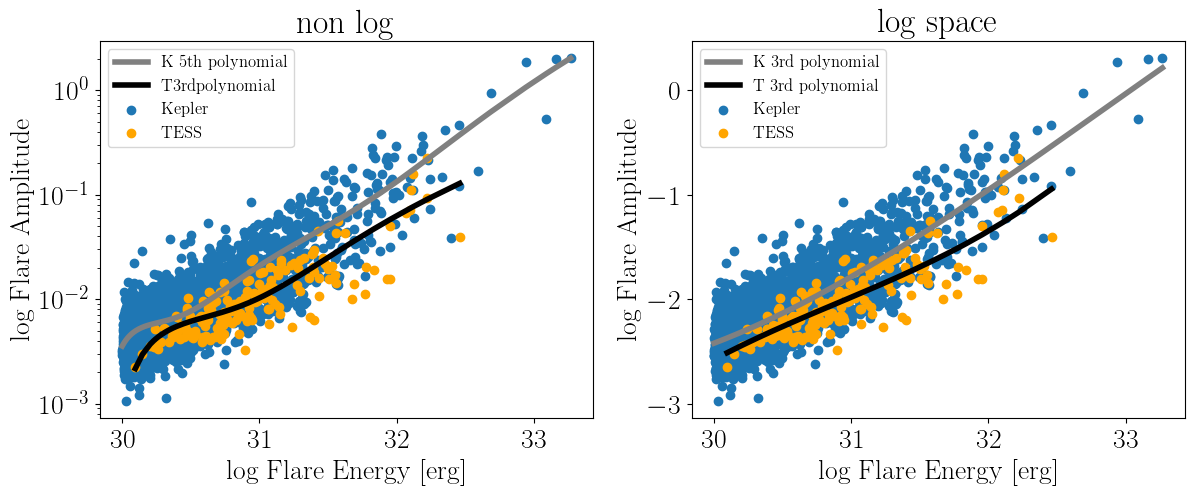

In [378]:
fig, axs = plt.subplots(1,2, figsize=(14,5), facecolor='w', edgecolor='k')


axs[0].scatter(kep_xfit,kep_yfit,label='Kepler')
axs[0].plot(kep_sorted, kep_p(kep_sorted), '-',color='grey',lw=4,label='K 5th polynomial')


axs[0].scatter(tess_xfit,tess_yfit,color='orange',label='TESS')
axs[0].plot(tess_sorted, tess_p(tess_sorted), '-',color='k',lw=4,label='T3rdpolynomial')
axs[0].set_yscale('log')
axs[0].set_xlabel('log Flare Energy [erg]')
axs[0].set_ylabel('log Flare Amplitude')
axs[0].legend(fontsize=12)
axs[0].set_title('non log')


axs[1].scatter(kep_xfit,kep_yfit_log,label='Kepler')
axs[1].plot(kep_sorted, kep_p_log(kep_sorted), '-',color='grey',lw=4,label='K 3rd polynomial')


axs[1].scatter(tess_xfit,tess_yfit_log,color='orange',label='TESS')
axs[1].plot(tess_sorted, tess_p_log(tess_sorted), '-',color='k',lw=4,label='T 3rd polynomial')


#plt.yscale('log')
axs[1].set_xlabel('log Flare Energy [erg]')
axs[1].set_ylabel('log Flare Amplitude')
axs[1].legend(fontsize=12)
axs[1].set_title('log space')

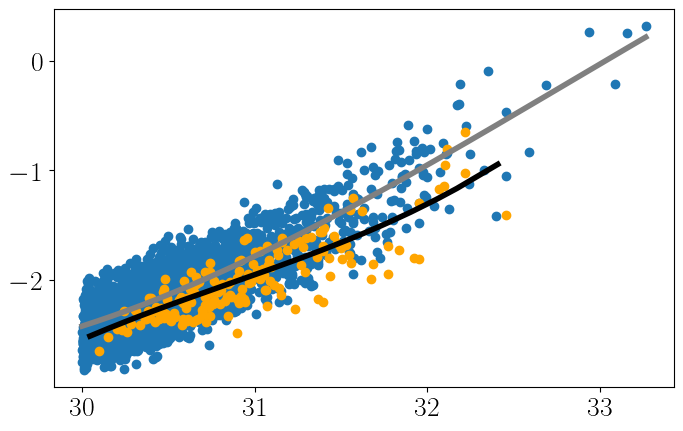

In [445]:
plt.scatter(kep_xfit,kep_yfit_log,label='Kepler')
plt.plot(kep_sorted, kep_p_log(kep_sorted), '-',color='grey',lw=4,label='K 3rd polynomial')

plt.scatter(tess_xfit,tess_yfit_log,color='orange',label='TESS')
plt.plot(tess_sorted-.05, tess_p_log(tess_sorted), '-',color='k',lw=4,label='T 3rd polynomial')

In [379]:
print(len(tess_yfit_log))
print(len(kep_yfit_log))

print(len(kep_xfit))
print(len(tess_xfit))

177
2373
2373
177


Interpolating to compare tess to kepler data points

In [380]:
interp_tess = np.interp(kep_yfit_log,tess_xfit,tess_yfit_log)
print(len(interp_tess))

2373


In [381]:
interp_tess2 = np.interp(tess_yfit_log,kep_xfit,kep_yfit_log)
print(len(interp_tess2))

177


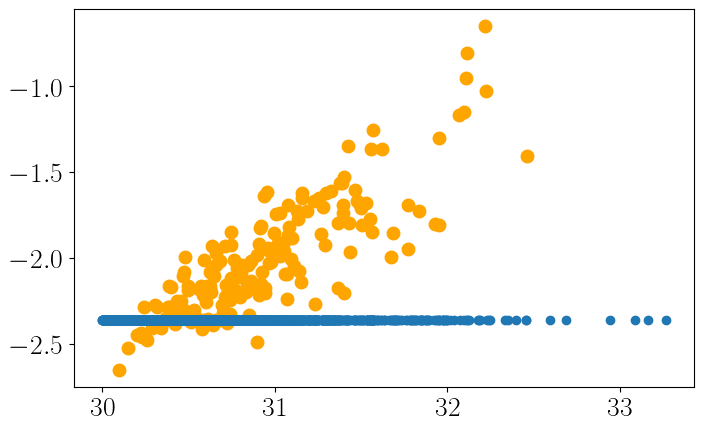

In [382]:
plt.scatter(tess_xfit,tess_yfit_log,color='orange',lw=4,label='polynomial')
plt.scatter(kep_xfit,interp_tess,color='C0',label='interp_tess')

In [383]:
print(len(interp_tess))
print(len(kep_yfit))

2373
2373


In [384]:
print(interp_tess/kep_yfit)

[-297.64823718 -247.96235626 -327.99534556 ... -203.78064372 -203.78064372
 -280.36938613]


In [385]:
print('Log Flux Ratio:',interp_tess/kep_yfit)
#print('log Flux Ratio:',np.log10(interp_tess/kep_yfit))

Log Flux Ratio: [-297.64823718 -247.96235626 -327.99534556 ... -203.78064372 -203.78064372
 -280.36938613]


In [386]:
np.sum(interp_tess)

-5601.715521534499

In [387]:
np.sum(kep_yfit_log)

-4943.105130217955

In [388]:
kep_yfit = flare_table['flux peak'].values[gt30]
kep_yfit_log = np.log10(kep_yfit)
tess_xfit =tess_energy_full[tess_maskgt30]
interp_tess = np.interp(kep_yfit_log,tess_xfit,tess_yfit_log)

print('Log Flux Ratio:',np.sum(interp_tess)/np.sum(kep_yfit_log))

Log Flux Ratio: 1.1150052668223998


In [389]:
#tess_z_log,tcov = np.polyfit(tess_xfit,tess_yfit_log,3,cov=True)
#tess_p_log = np.poly1d(tess_z_log)

print(kep_p_log(32))
print(tess_p_log(32))
print(tess_p_log(32)/kep_p_log(32)) #log space needs to be subtracted not divided

-0.9536904543235778
-1.3486392301017531
1.414126799725913


In [390]:
print(tess_p_log(32)-kep_p_log(32)) # this shows tess is fainter by 0.3 dex in flux

-0.39494877577817533


In [391]:
print(10**tess_p_log(32) / 10**kep_p_log(32))
print(10**kep_p_log(32) / 10**tess_p_log(32)) #kepler flares are twice as high based on 3rd order polynomial fits from above at 10^32 erg

0.40276453684776703
2.4828402416620166


In [392]:
print(10**tess_p_log(31) / 10**kep_p_log(31))
print(10**kep_p_log(31) / 10**tess_p_log(31)) #kepler flares are 1.5 as high based on 3rd order polynomial fits from above at 10^31erg

0.6361253754143683
1.5720171504691287


In [393]:
print(10**tess_p_log(30.5) / 10**kep_p_log(30.5))
print(10**kep_p_log(30.5) / 10**tess_p_log(30.5)) #kepler flares are 1.5 as high based on 3rd order polynomial fits from above at 10^31erg

0.745460203457052
1.3414532329995974


In [444]:
print(10**tess_p_log(30) / 10**kep_p_log(30))
print(10**kep_p_log(30) / 10**tess_p_log(30))

0.6974921571714023
1.433707877168659


In [394]:
np.log(1.1150052668223998)

0.10885912850845929

In [195]:
interp_tess

array([-2.36060494, -2.36060494, -2.36060494, ..., -2.36060494,
       -2.36060494, -2.36060494])

Importing in Flux Ratio Conversion to Temperature -- 3rd order polynomial fit from isochron data

In [395]:
iso_pfit = pd.read_csv('polyfit.csv')
iso_pfit

,log temp,flux ratio
0,3.700372,1.607331
1,3.705163,1.596032
2,3.709959,1.584251
3,3.714647,1.572330
4,3.719324,1.560085
...,...,...
446,4.605286,0.799347
447,4.616918,0.798818
448,4.628549,0.798465
449,4.640180,0.798312


Text(0, 0.5, 'flux ratio')

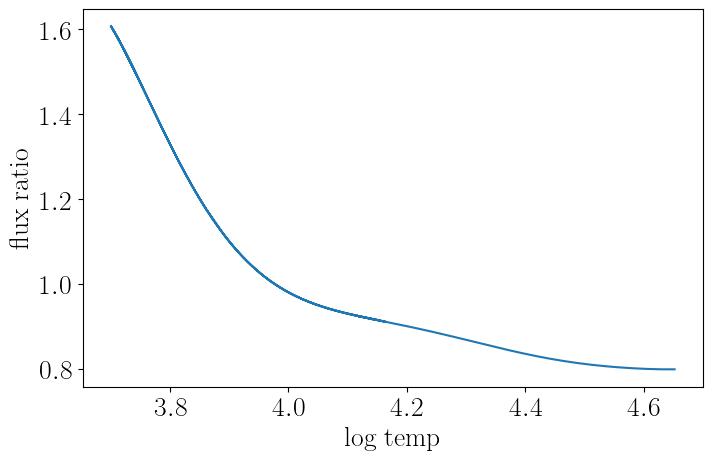

In [396]:
plt.plot(iso_pfit['log temp'].values, iso_pfit['flux ratio'].values)
#plt.plot(kep_xfit,interp_tess)


plt.xlabel('log temp')
plt.ylabel('flux ratio')

In [397]:
full_tess


,Event_ID,Start_INDX,Stop_INDX,t_peak,t_start,t_stop,t_rise,t_decay,Flux_peak,Equiv_Dur,S/N,CPLX_flg,MLTPK_flg,MLTPK_num,t_MLTPK,L_mltpk,MLTPK_INDX,quies,x,Flare_Duration
1,2,332.0,336.0,1683.831182,1683.828405,1683.833960,0.002778,0.002778,0.004359,1.039416,0.856315,4.0,0.0,0.0,0.0,0.0,0.0,11337.21094,;,8.000106
2,3,618.0,622.0,1684.233965,1684.232576,1684.238132,0.001389,0.004167,0.004396,1.021397,0.698504,4.0,0.0,0.0,0.0,0.0,0.0,11377.51562,;,8.000103
3,4,676.0,685.0,1684.315911,1684.313133,1684.325633,0.002778,0.009722,0.011388,4.056827,1.721060,4.0,0.0,0.0,0.0,0.0,0.0,11337.41602,;,18.000231
4,5,1619.0,1628.0,1685.624261,1685.622872,1685.635372,0.001389,0.011111,0.007767,2.732755,1.365432,4.0,0.0,0.0,0.0,0.0,0.0,11342.76758,;,18.000222
5,6,1655.0,1661.0,1685.674261,1685.672872,1685.681206,0.001389,0.006945,0.006291,1.887355,1.065632,4.0,0.0,0.0,0.0,0.0,0.0,11338.58984,;,12.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,57,10134.0,10142.0,2435.203239,2435.197683,2435.208794,0.005556,0.005556,0.004420,1.816458,1.095057,4.0,0.0,0.0,0.0,0.0,0.0,11302.00879,;,15.999987
48,58,10750.0,10849.0,2436.058794,2436.054627,2436.192127,0.004167,0.133333,0.039386,127.881465,10.561373,1.0,0.0,0.0,0.0,0.0,0.0,11299.08105,;,197.999829
49,59,11061.0,11084.0,2436.492127,2436.486571,2436.518515,0.005556,0.026389,0.011841,8.704707,2.393503,2.0,0.0,0.0,0.0,0.0,0.0,11317.58105,;,45.999958
50,60,13780.0,13797.0,2440.281011,2440.272677,2440.296288,0.008333,0.015278,0.006244,3.916223,1.463201,1.0,0.0,0.0,0.0,0.0,0.0,11324.44336,;,33.999943


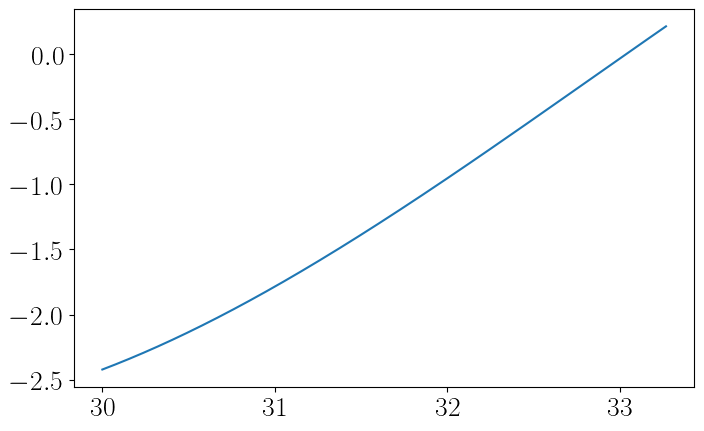

In [398]:
plt.plot(kep_sorted, kep_p_log(kep_sorted))

In [402]:
print(kep_p_log)
print(kep_z_log)

          3         2
-0.01786 x + 1.758 x - 56.77 x + 600.5
[-1.78562297e-02  1.75812733e+00 -5.67721532e+01  6.00545766e+02]


In [403]:
a1,b1,c1,d1 = [ -1.78562297e-02,  1.75812733e+00, -5.67721532e+01,  6.00545766e+02]

In [404]:
th = a1,b1,c1,d1
poly3(th,kep_sorted)

array([-2.4223285 , -2.42232741, -2.42211351, ...,  0.04843218,
        0.11464948,  0.2133016 ])

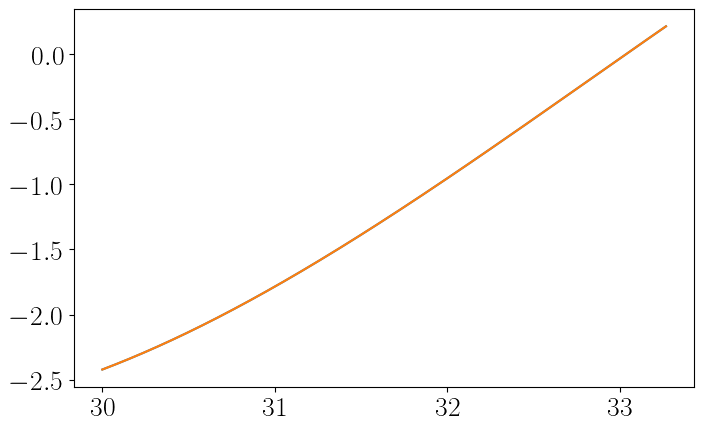

In [405]:
plt.plot(kep_sorted,poly3(th,kep_sorted))
plt.plot(kep_sorted, kep_p_log(kep_sorted))

In [284]:
#kyerr= np.sqrt(np.diag(cov))
#print(kyerr)

[1.30754533e-02 1.22257787e+00 3.80930203e+01 3.95516123e+02]


In [290]:
len(kyerr)

4

#### Fitting with MCMC

In [219]:
import emcee
from IPython.display import display, Math
import corner

In [406]:
def poly3(theta,x):
    a,b,c,d = theta
    poly_3 = a*x**3 + b*x**2 + c*x + d
    return poly_3

def log_likelihood(theta, x, y,kepler_errors):
    #a,b,c,d = theta
    model = poly3(theta,x)
    lnlike = -0.5 * (np.sum(((y-model)**2/kepler_errors)**2))
    return lnlike

def log_prior(theta):
    a,b,c,d = theta
    #if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        #return 0.0
    return 0.

def log_probability(theta, x, y,kepler_errors):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y,kepler_errors)

In [407]:
init = np.array([a1,b1,c1,d1])
nwalkers=64
ndim = len(init)
pos = [np.array(init) + 1e-4 *np.random.rand(ndim) for i in range(nwalkers)]


ksort = np.argsort(kep_xfit)
data = (kep_xfit[ksort],kep_yfit_log[ksort],kepler_errors[ksort])

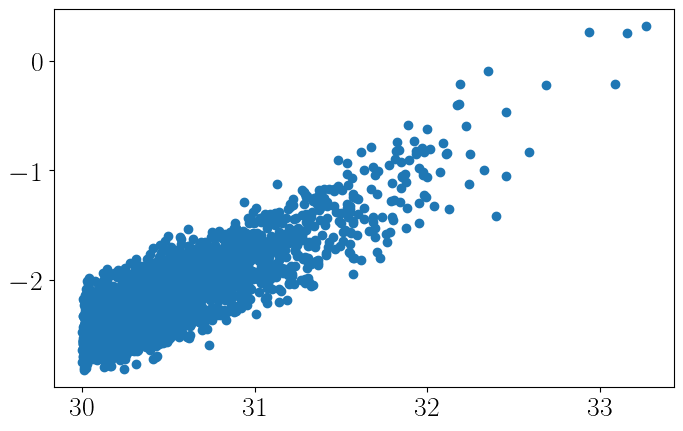

In [429]:
plt.scatter(kep_xfit[ksort],kep_yfit_log[ksort])

In [408]:
kep_xfit[ksort]

array([30.00021123, 30.00021341, 30.00063798, ..., 33.0888787 ,
       33.16048907, 33.26756636])

In [409]:

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=data
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [04:41<00:00, 35.47it/s]


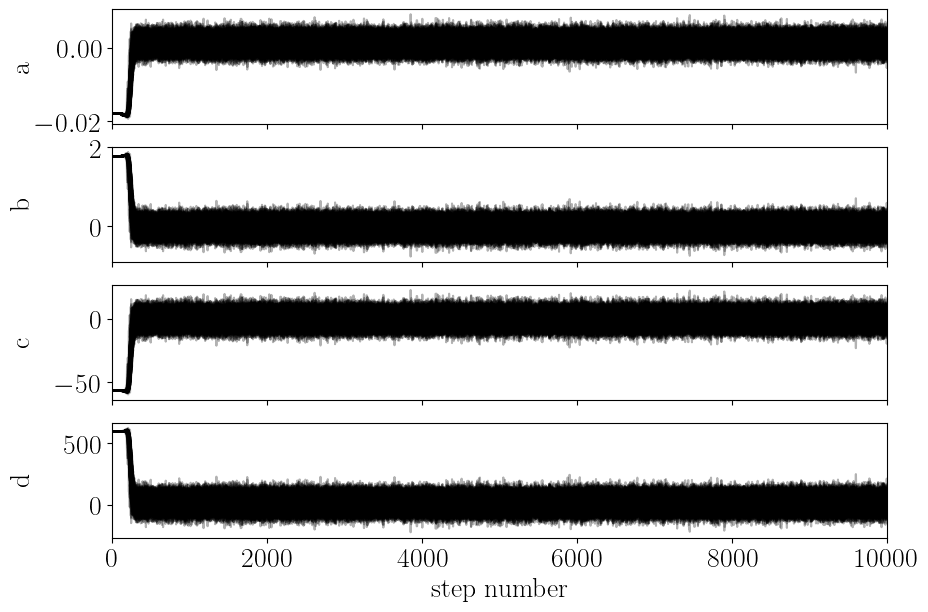

In [410]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c","d"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [411]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [205.22749327 205.54576092 205.82330481 206.09175386]

In [412]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(153600, 4)


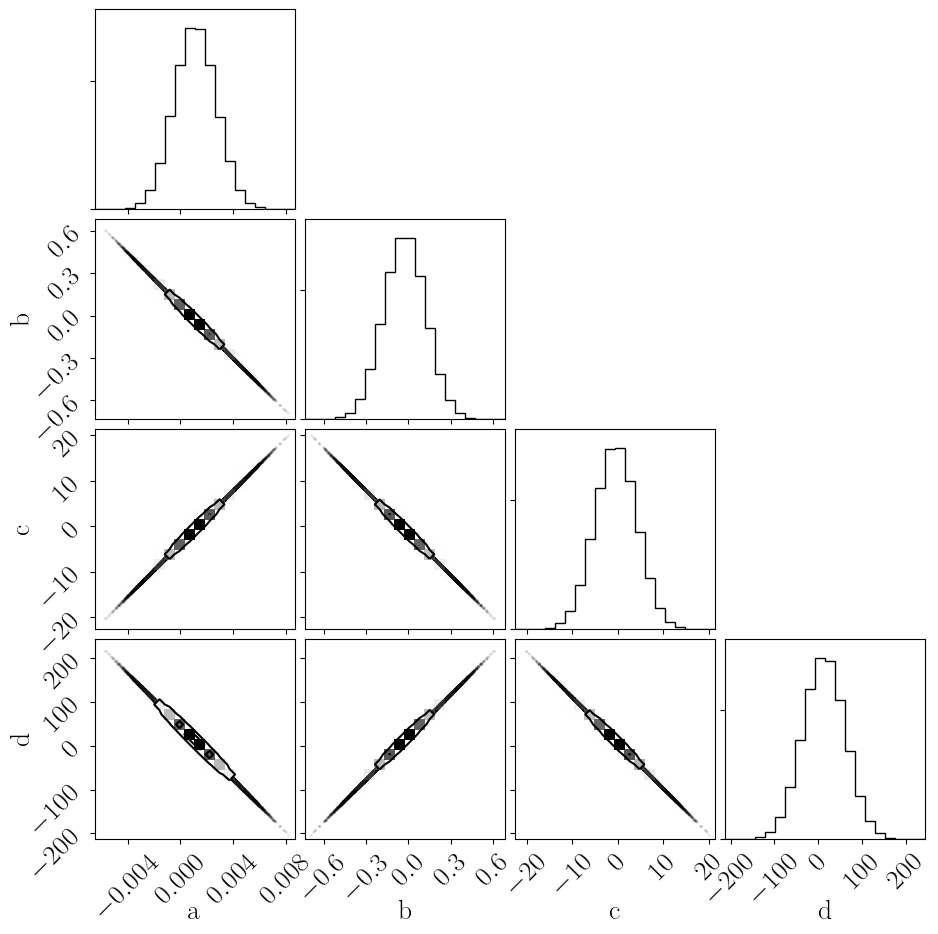

In [413]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[a1,b1,c1,d1]
);

In [414]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [419]:
print(np.median(flat_samples,axis=0))

[ 1.07903551e-03 -2.94728346e-02 -5.68331416e-01  1.19223893e+01]


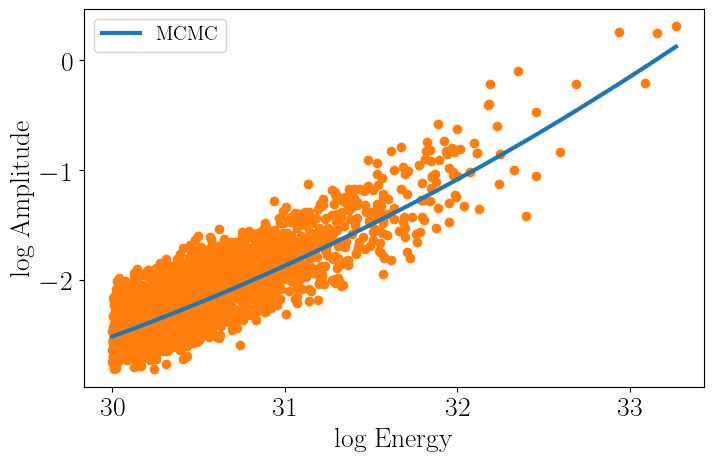

In [443]:
#inds = np.random.randint(len(flat_samples), size=100)
#for ind in inds:
    #sample = flat_samples[ind]
plt.scatter(kep_xfit[ksort], kep_yfit_log[ksort], color="C1")
plt.plot(kep_xfit[ksort],poly3((np.median(flat_samples,axis=0)),kep_xfit)[ksort],label='MCMC',color='C0',lw=3)
#plt.errorbar(x, y,  fmt=".k", capsize=0)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel("log Energy")
plt.ylabel("log Amplitude");

### Splitting up Max's Flare data

In [124]:
### Splitting up Max's Flare data ####
teff_mask = max2020['Teff']!=max2020['Teff'][0]
teff_array = np.array(max2020['Teff'].values[teff_mask],dtype = float)
max2020['Teff'].values

In [125]:
teff_array

array([3041., 3041., 3041., ..., 3319., 3319., 5036.])

In [126]:
teff_mask = np.where((teff_array >= 3200) & (teff_array <= 3300))[0]

In [128]:
print(len(teff_array[teff_mask]))

1278


(array([ 40.,  61., 101.,  56., 153., 189., 215.,  93., 234., 136.]),
 array([3200., 3210., 3220., 3230., 3240., 3250., 3260., 3270., 3280.,
        3290., 3300.]),
 <BarContainer object of 10 artists>)

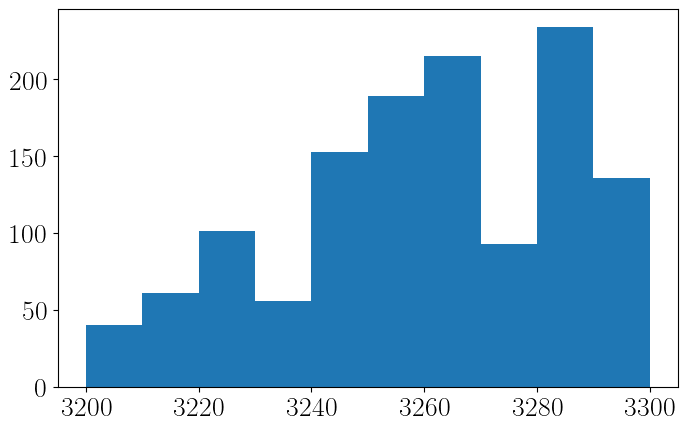

In [129]:
plt.hist(teff_array[teff_mask])